In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


In [2]:

df = pd.read_csv('../data/IMDB Dataset_az.csv')
df = df[['review_az', 'sentiment']]
df.rename(columns={'review_az': 'text'}, inplace=True)
df.rename(columns={'sentiment': 'label'}, inplace=True)

In [3]:
def split_sentences(text):
    pattern = r'(?<=[.!?])\s*'
    sentences = re.split(pattern, text)
    sentences_with_whitespace = ' '.join(sentences)
    return sentences_with_whitespace

df['text'] = df['text'].apply(split_sentences)
df['text'] = df['text'].apply(lambda x: x.lower())

In [56]:


# Function to create term-document matrix
def create_term_document_matrix(documents):
    word_counts = Counter()
    for doc in documents:
        word_counts.update(doc.split())

    vocabulary = sorted(word_counts.keys())
    vocab_index = {word: i for i, word in enumerate(vocabulary)}

    matrix = np.zeros((len(vocabulary), len(documents)), dtype=np.int32)
    for doc_id, doc in enumerate(documents):
        for word in doc.split():
            matrix[vocab_index[word], doc_id] += 1

    return matrix, vocabulary

# Function to create word-word matrix
def create_word_word_matrix(documents):
    word_counts = Counter()
    for doc in documents:
        word_counts.update(doc.split())

    vocabulary = sorted(word_counts.keys())
    vocab_index = {word: i for i, word in enumerate(vocabulary)}

    matrix = np.zeros((len(vocabulary), len(vocabulary)), dtype=np.int32)
    for doc in documents:
        words = doc.split()
        for i in range(len(words)):
            for j in range(i+1, len(words)):
                word_i, word_j = words[i], words[j]
                matrix[vocab_index[word_i], vocab_index[word_j]] += 1
                matrix[vocab_index[word_j], vocab_index[word_i]] += 1

    return matrix, vocabulary

# Function to calculate TF-IDF features
def calculate_tf_idf(matrix):
    tf = matrix / np.sum(matrix, axis=0)
    idf = np.log(matrix.shape[1] / np.count_nonzero(matrix, axis=1))
    return tf * idf[:, np.newaxis]

# Function to calculate PMI features
EPSILON = 1e-8
def calculate_pmi(matrix):
    total_word_count = np.sum(matrix)
    word_count_per_document = np.sum(matrix, axis=1)
    word_frequency = word_count_per_document / total_word_count
    word_pair_prob = matrix / total_word_count

    pmi_matrix = np.zeros_like(matrix, dtype=np.float64)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            pmi_matrix[i, j] = np.log((word_pair_prob[i, j] + EPSILON) / ((word_frequency[i] + EPSILON) * (word_frequency[j] + EPSILON)))

    return pmi_matrix



class CustomLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01, num_iter=100, fit_intercept=True, reg_param=0.1):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.reg_param = reg_param

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        self.theta = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            reg_term = self.reg_param * self.theta / y.size 
            self.theta -= self.lr * (gradient + reg_term)

    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return np.column_stack((1 - self.__sigmoid(np.dot(X, self.theta)), self.__sigmoid(np.dot(X, self.theta))))

    def predict(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return (self.__sigmoid(np.dot(X, self.theta)) >= 0.5).astype(int)

    def score(self, X, y):
        return (self.predict(X) == y).mean()


def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def most_similar_words(word, word_vectors, vocab, top_n=10):
    if word not in vocab:
        return []

    word_index = vocab.index(word)
    similarities = []
    for i, vec in enumerate(word_vectors):
        if i != word_index:
            sim = cosine_similarity(word_vectors[word_index], vec)
            similarities.append((vocab[i], sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

In [57]:
# df = df.sample(1000, random_state=42)
# documents = df['text'].tolist()

# word_word_matrix, vocab_word_word = create_word_word_matrix(documents)
# pmi_features = calculate_pmi(word_word_matrix)

In [58]:

# Step 1: Create term-document and word-word matrix
documents = df['text'].tolist()
term_doc_matrix, vocab_term_doc = create_term_document_matrix(documents)
# word_word_matrix, vocab_word_word = create_word_word_matrix(documents)

# Visualize matrices
print("Term-Document Matrix:")
print(term_doc_matrix)
# print("\nWord-Word Matrix:")
# print(word_word_matrix)

# Step 2: Calculate TF-IDF features
tf_idf_features = calculate_tf_idf(term_doc_matrix)
print("\nTF-IDF Features:")
print(tf_idf_features)

# Step 3: Calculate PMI features
# pmi_features = calculate_pmi(word_word_matrix)
# print("\nPMI Features:")
# print(pmi_features)

# Step 4: Apply Logistic Regression for classification
# X = tf_idf_features.T  # Transpose because logistic regression expects features as rows and samples as columns
# y = df['label'].values
# model = CustomLogisticRegression()
# losses = model.fit(X, y)
# predictions_lr = model.predict(X)

# Compare with Naive Bayes (Assuming you have implemented Naive Bayes)
# ...

# Step 5: Find 10 most similar words
# word = 'insan'
# similar_words = most_similar_words(word, tf_idf_features, vocab_term_doc)
# print(f"\n10 most similar words to '{word}':")
# for w, sim in similar_words:
#     print(f"{w}: {sim}")


Term-Document Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

TF-IDF Features:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:

# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Initialize and fit Logistic Regression model
    # model = CustomLogisticRegression(lr=2, num_iter=1000)
    # losses = model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluation metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)

    train_report = classification_report(y_train, y_pred_train)
    test_report = classification_report(y_test, y_pred_test)

    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)

    return {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train F1 Score': train_f1,
        'Test F1 Score': test_f1,
        'Train Classification Report': train_report,
        'Test Classification Report': test_report,
        'Train Confusion Matrix': train_confusion_matrix,
        'Test Confusion Matrix': test_confusion_matrix
    }


In [30]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(tf_idf_features.T, df['label'].values, test_size=0.2, random_state=42)

# Evaluate the model
evaluation_results, losses = evaluate_model(model, X_train, X_test, y_train, y_test)

# Print evaluation results
for metric, value in evaluation_results.items():
    print(f'{metric}:')
    print(value)
    print()


Train Accuracy:
0.950625

Test Accuracy:
0.7525

Train F1 Score:
0.9501577287066246

Test F1 Score:
0.7681498829039812

Train Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       801
           1       0.96      0.94      0.95       799

    accuracy                           0.95      1600
   macro avg       0.95      0.95      0.95      1600
weighted avg       0.95      0.95      0.95      1600


Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.73       199
           1       0.73      0.82      0.77       201

    accuracy                           0.75       400
   macro avg       0.76      0.75      0.75       400
weighted avg       0.76      0.75      0.75       400


Train Confusion Matrix:
[[768  33]
 [ 46 753]]

Test Confusion Matrix:
[[137  62]
 [ 37 164]]



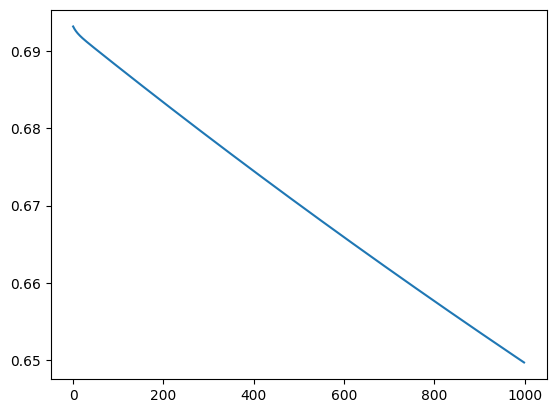

In [22]:
plt.plot(losses);

In [53]:
def random_search(X_train, y_train):
    param_grid = {
        'lr': uniform(0.01, 1),
        'num_iter': [500, 1000, 5000, 10000],
        'reg_param': [0.001, 0.01, 0.1, 1]
    }
    model = CustomLogisticRegression()
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    return best_params

X_train, X_test, y_train, y_test = train_test_split(tf_idf_features.T, df['label'].values, test_size=0.2, random_state=42)

best_params = random_search(X_train, y_train)
print("Best parameters found:", best_params)
model = CustomLogisticRegression(lr=best_params['lr'], num_iter=best_params['num_iter'])
model.fit(X_train, y_train)

evaluation_results, losses = evaluate_model(model, X_train, X_test, y_train, y_test)
for metric, value in evaluation_results.items():
    print(f'{metric}:')
    print(value)
    print()


/Users/eljan/anaconda3/envs/polygraf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/eljan/anaconda3/envs/polygraf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 977, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/eljan/anaconda3/envs/polygraf/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/eljan/anaconda3/envs/polygraf/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
 

Best parameters found: {'lr': 0.3845401188473625, 'num_iter': 500, 'reg_param': 0.1}
Train Accuracy:
0.899375

Test Accuracy:
0.6975

Train F1 Score:
0.8891947694425327

Test F1 Score:
0.6109324758842444

Train Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       801
           1       0.99      0.81      0.89       799

    accuracy                           0.90      1600
   macro avg       0.91      0.90      0.90      1600
weighted avg       0.91      0.90      0.90      1600


Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.92      0.75       199
           1       0.86      0.47      0.61       201

    accuracy                           0.70       400
   macro avg       0.75      0.70      0.68       400
weighted avg       0.75      0.70      0.68       400


Train Confusion Matrix:
[[793   8]
 [153 646]]

Test Confusion Matrix:
[[184  15]


In [37]:
# Best parameters found: {'lr': 0.3845401188473625, 'num_iter': 500}
# Train Accuracy:
# 0.950625

# Test Accuracy:
# 0.7525

# Train F1 Score:
# 0.9501577287066246

# Test F1 Score:
# 0.7681498829039812

# Train Classification Report:
#               precision    recall  f1-score   support

#            0       0.94      0.96      0.95       801
#            1       0.96      0.94      0.95       799

#     accuracy                           0.95      1600
#    macro avg       0.95      0.95      0.95      1600
# weighted avg       0.95      0.95      0.95      1600


# Test Classification Report:
#               precision    recall  f1-score   support

#            0       0.79      0.69      0.73       199
#            1       0.73      0.82      0.77       201

#     accuracy                           0.75       400
#    macro avg       0.76      0.75      0.75       400
# weighted avg       0.76      0.75      0.75       400


# Train Confusion Matrix:
# [[768  33]
#  [ 46 753]]

# Test Confusion Matrix:
# [[137  62]
#  [ 37 164]]

In [80]:
model = CustomLogisticRegression(lr=0.5, num_iter=1000, reg_param=1)
model.fit(X_train, y_train)
evaluation_results, losses = evaluate_model(model, X_train, X_test, y_train, y_test)

for metric, value in evaluation_results.items():
    print(f'{metric}:')
    print(value)
    print()

Train Accuracy:
0.936875

Test Accuracy:
0.7525

Train F1 Score:
0.9344581440622972

Test F1 Score:
0.7480916030534351

Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       801
           1       0.97      0.90      0.93       799

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600


Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       199
           1       0.77      0.73      0.75       201

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400


Train Confusion Matrix:
[[779  22]
 [ 79 720]]

Test Confusion Matrix:
[[154  45]
 [ 54 147]]



In [27]:

X_train, X_test, y_train, y_test = train_test_split(tf_idf_features.T, df['label'].values, test_size=0.2, random_state=42)

model = CustomLogisticRegression(lr=0.1, num_iter=500, reg_param=1)
model.fit(X_train, y_train)
evaluation_results = evaluate_model(model, X_train, X_test, y_train, y_test)

for metric, value in evaluation_results.items():
    print(f'{metric}:')
    print(value)
    print()


Train Accuracy:
0.536875

Test Accuracy:
0.5025

Train F1 Score:
0.14925373134328357

Test F1 Score:
0.02926829268292683

Train Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.99      0.68       801
           1       0.90      0.08      0.15       799

    accuracy                           0.54      1600
   macro avg       0.71      0.54      0.42      1600
weighted avg       0.71      0.54      0.42      1600


Test Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.99      0.67       199
           1       0.75      0.01      0.03       201

    accuracy                           0.50       400
   macro avg       0.62      0.50      0.35       400
weighted avg       0.63      0.50      0.35       400


Train Confusion Matrix:
[[794   7]
 [734  65]]

Test Confusion Matrix:
[[198   1]
 [198   3]]



In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Vectorize text data
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



# Predictions
y_pred = model.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_train, y_pred))

Accuracy: 0.82
F1 Score: 0.8260869565217391
Confusion Matrix:
 [[157  42]
 [ 30 171]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81       199
           1       0.80      0.85      0.83       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

Accuracy: 0.97375
F1 Score: 0.9737827715355806
Confusion Matrix:
 [[778  23]
 [ 19 780]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       801
           1       0.97      0.98      0.97       799

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600



In [46]:
df.shape

(2000, 2)

In [88]:

text1 = 'Film çox yaxşı idi. Çox xoşuma gəldi.'
text2 = 'Film çox pis idi. Çox xoşuma gəlmədi.'
text3 = 'Indiye qeder izlediyim en möhtəşəm film idi.'
text4 = 'Yusif çox pis adam idi. Çox xoşuma gəlmədi.'
text5 = 'Filmi izləmək istəmirəm. Çox pis idi.'
text6 = 'Filmi bəyəndim, baxmağa dəyər.'
text7 = 'Filmi bəyənmədim izləməyi tövsiyyə etmirəm.'
text = "Film çox əyləncəli idi."

new_text_vectorized = tfidf_vectorizer.transform([text2.lower()])
predicted_label = model.predict(new_text_vectorized)
predicted_label = predicted_label[0]
print(predicted_label)

0


In [79]:
def second_sim(given_word):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np

    corpus = df['text'].tolist()

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

    feature_names = tfidf_vectorizer.get_feature_names_out()


    try:
        word_index = feature_names.tolist().index(given_word)
    except ValueError:
        print(f"The word '{given_word}' is not in the vocabulary.")
    else:
        word_vector = tfidf_matrix[:, word_index]
        similarities = cosine_similarity(tfidf_matrix.T, word_vector.T).flatten()
        most_similar_word_indices = similarities.argsort()[-11:-1][::-1] 

        # Map indices to words
        most_similar_words = [feature_names[i] for i in most_similar_word_indices]

        print(most_similar_words)

second_sim(given_word='bəyənmədim')

['baxışlar', 'bəyəndiyinizi', 'səmimidir', 'gəlmirlər', 'başladın', 'mənalıdır', 'oyandıraraq', 'olunmasına', 'bantın', 'bantı']


In [81]:
word = 'bəyəndim'
similar_words = most_similar_words(word, tf_idf_features, vocab_term_doc)
print(f"\n10 most similar words to '{word}':")
for w, sim in similar_words:
    print(f"{w}: {sim}")


10 most similar words to 'bəyəndim':
(samantha: 0.7869332032190166
bravo!: 0.7869332032190166
olanda).: 0.7869332032190166
stansiya: 0.7845372906768673
flört: 0.7722683341951694
ləqəb: 0.7603623560825417
bilməz!: 0.7464255628829782
oteldə: 0.7355853059430344
oxumağı: 0.7174692276295543
səhnəyə: 0.6280834834525226


In [89]:
# calculate number of unique words
unique_words = set()
for doc in documents:
    unique_words.update(doc.split())   
print(len(unique_words))

58550
